### Deep Learning for Images with PyTorch

#### Images
Images consist of pixels, each of which contains color information (ints from 0 - 255; one channel if grayscale and three if RGB).

#### Loading images to PyTorch
Use `ImageFolder` from `torchvision` to create a `Dataset` of images from a dataset on disk, or download a sample one such as `MNIST` from `torchvision`.

#### Transformation argument
Use `Compose()` and the assortment of transformation options from `torchvision.transforms` to pack image transformations into an argument passed to dataset preprocessing / data augmentation.

torch.Size([1, 1, 128, 128])
torch.Size([128, 128])


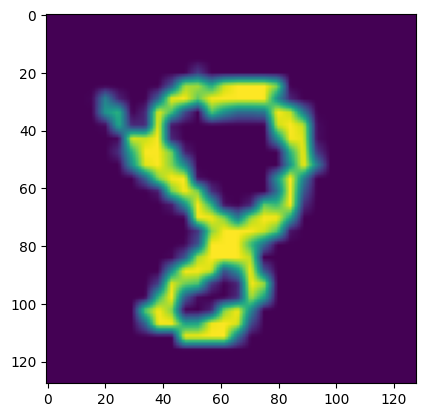

In [ ]:
import torch
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.datasets import MNIST
from torchvision import transforms

train_transforms = transforms.Compose([
    # Data augmentation: random transformations to original images generate more data
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(), # parse to tensor
    transforms.Resize((128, 128)) # resize to 128x128px
])

# dataset_train = ImageFolder("data/clouds_train", transform=train_transforms)
dataset_train = MNIST("data/mnist", transform=train_transforms, download=True) # download the MNIST dataset
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)

image, label = next(iter(dataloader_train))
print(image.shape)

image = image.permute(1, 2, 3, 0).squeeze()
print(image.shape)

# @@@ Displaying an Image @@@
import matplotlib.pyplot as plt

plt.imshow(image)
plt.show()

#### Convolutional Neural Networks (CNNs)
The number of parameters potentially needed to assign a neuron to each pixel of an image blows up untenably (for instance, a 256x256px grayscale image has 65,536 model inputs, and a linear layer with 1,000 neurons would result in over 65 million parameters).

This many parameters slows training and risks overfitting, and using a linear layer this way fails to capture spatial information about pixels in proximity or objects in different locations.

In a convolutional layer, parameters are collected gridwise using one or more small grids called "filters." These filters slide over the input and perform convolution operations aat each position to create a feature map, which perserves spatial patterns from the input and uses much fewer parameters than a layer layer would. One filter = one outputted feature map, and an activation is applied to each one; all feature maps combined form the output of a convolutional layer.

In PyTorch, use `nn.Conv2d(x, y, kernel_size)` to instantiate a convolutional layer, where `x` is the number of input feature maps and `y` is the number of output feature maps.

In deep learning, a convolution is the dot product between two arrays, the input patch and the filter (elementwise multiplication and summing).

#### Padding and pooling

Before being processed, oftentimes a convolutional layer's input is zero-padded (has zeros added around it) via the padding argument (`nn.Conv2d(x, y, kernel_size, padding)`) in the convolutional layer. It maintains the spatial dimensions of the input and output as well as equal representation of border pixels (which would otherwise be filtered fewer times than the others, potentially resulting in information loss).

Max pooling is another operation commonly used after convolutional layers; it involves sliding a non-overlapping window over the input and taking the max value from each window to pass forward, reducing the spatial dimensions of the feature maps and thereby reducing paramater count and computational complexity in the network.

In PyTorch, use `nn.MaxPool2d(kernel_size)` to instantiate a max pooling layer.

In [8]:
import torch.nn as nn

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # (convolution, activation, pooling) x2, flattened
        self.feature_extractor = nn.Sequential(
            # 3 corresponds to RGB channels; 3x3 filters, 1 layer of zero-padding
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 3 channels --> 32 output feature maps
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # size 2 window halves feature map's dimensions
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten() # flattens feature extraction output into vector
        )
        self.classifier = nn.Linear(64*16*16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

#### Training image classifiers

Data augmentation is useful for synthesizing more data, but only if the label is generally preserved (for instance, a picture of an 'M' flipped to look more like a 'W' would likely confuse the model). Examples of `torchvision.transforms` transformations used for data augmentation:
- Random rotation (`transforms.RandomRotation(45)`)
- Vertical / horizontal flip (e.g. `transforms.RandomHorizontalFlip()`)
- Auto contrast adjustment (`transforms.RandomAutocontrast()`)

These expose the model to different perspectives and lighting conditions of the same object, improving its robustness in recognizing objects in spite of environmental conditions.

In [10]:
import torch.optim as optim

net = ConvolutionalNeuralNetwork(num_classes=7)

# Use cross entropy loss for multiclass classification problems
criterion = nn.CrossEntropyLoss()
# gradient descender; remember, it's called an optimizer because it finds minimum of loss
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

#   for epoch in range(10):
#       for images, labels in dataloader_train:
#           optimizer.zero_grad()
#           predictions = net(images)
#           loss = criterion(predictions, labels)
#           loss.backward()

#### Evaluating image classifiers

First prepare the Dataset and DataLoader for test data. For test data, preprocessing must be defined without data augmentation (i.e. only parsing-to-tensor and resizing) because we want the model to predict a real test image, not a random transformation of it.

Model accuracy (frequency of correct predictions) is one metric of evaluation, but others include:
- in binary classification, precision = the fraction of correct predictions out of all positive predictions (% of predictions that were correct), and recall = fraction of correct predictions out of all positive examples (% of examples correctly predicted)
- in multiclass classification, we have separate precision and recall scores for each class, which can be analyzed **per-class** or aggregated by one of the following three operations:
    - Micro average: computes **global** precision/recall by counting total true positives, false positives, and false negatives across classes, then computing precision/recall from them.
        - Suited for imbalanced datasets (class-wise).
    - Macro average: computes the precision/recall per class indepedently, then **takes mean across all classes.**
        - Suited for performance on classes with fewer data points.
    - Weighted average: computes the precision/recall per class indepedently, then **takes weighted mean across all classes** (proportional to number of samples per class).
        - Suited for weighing errors in larger classes highly.

In [ ]:
from torchmetrics import Precision, Recall

recall_per_class = Recall(task="multiclass", num_classes=7, average=None)
recall_micro = Recall(task="multiclass", num_classes=7, average="micro")
recall_macro = Recall(task="multiclass", num_classes=7, average="macro")
recall_weighted = Recall(task="multiclass", num_classes=7, average="weighted")

# define precision / recall metrics
metric_precision = Precision(
    task="multiclass", num_classes=7, average="macro"
)
metric_recall = Recall(
    task="multiclass", num_classes=7, average="macro"
)
# iterate over test examples with no gradient
net.eval()
# with torch.no_grad():
#     for images, labels in dataloader_test:
#           outputs = net(images)
#           _, preds = torch.max(outputs, 1)
#           metric_precision(preds, labels)
#           metric_recall(preds, labels)
precision = metric_precision.compute()
recall = metric_recall.compute()
print("Precision:", precision)
print("Recall:", recall)

# dataset's class_to_idx attribute maps class names to indices of the outputted scores
# class-to-score dictionary comprehension:
# { k: recall[v].item() for k, v in dataset_test.class_to_idx.items() }

Precision: tensor(0.)
Recall: tensor(0.)


/Users/dummy/Documents/GitHub/ml-playground/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/Users/dummy/Documents/GitHub/ml-playground/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
